# Albumentations Tutorial for Data Augmentation

In [1]:
import albumentations as A
import cv2
from PIL import Image

In [2]:
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()


def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5

    for i in range(1, len(images)+1):
        if bboxes is not None:
            img = visualize_bbox(images[i - 1], bboxes[i - 1], class_name="Elon")
        else:
            img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()


# From https://albumentations.ai/docs/examples/example_bboxes/
def visualize_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img


## For classification

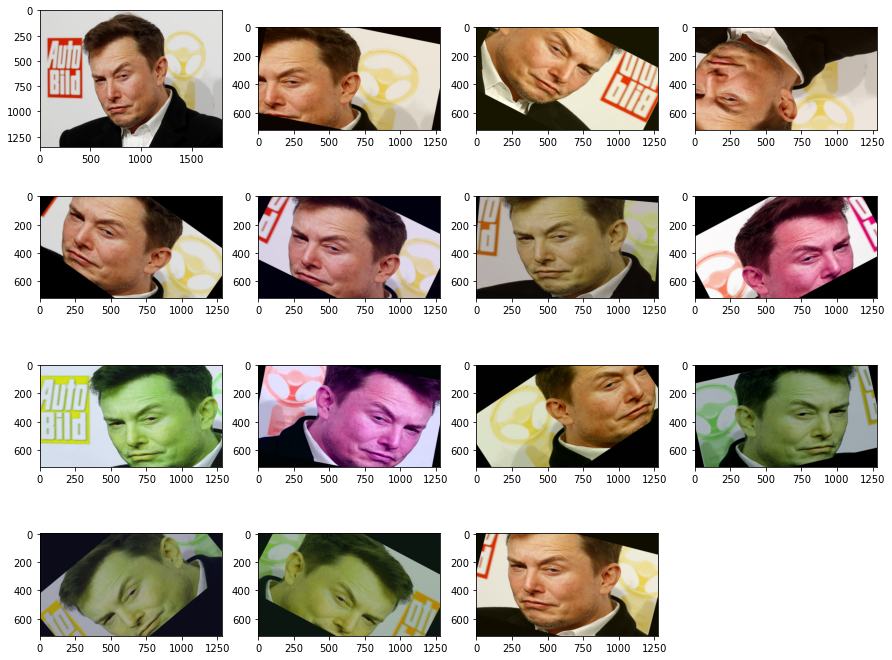

In [8]:
image = Image.open("images/elon.jpeg")

transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ],p=1.0),
        
    ]
)

images_list = [image]
image = np.array(image)

for i in range(15):
    augmentations = transform(image=image)
    augmented_img = augmentations["image"]
    images_list.append(augmented_img)
    
plot_examples(images_list)


## For Segmentation

ValueError: num must be 1 <= num <= 20, not 21

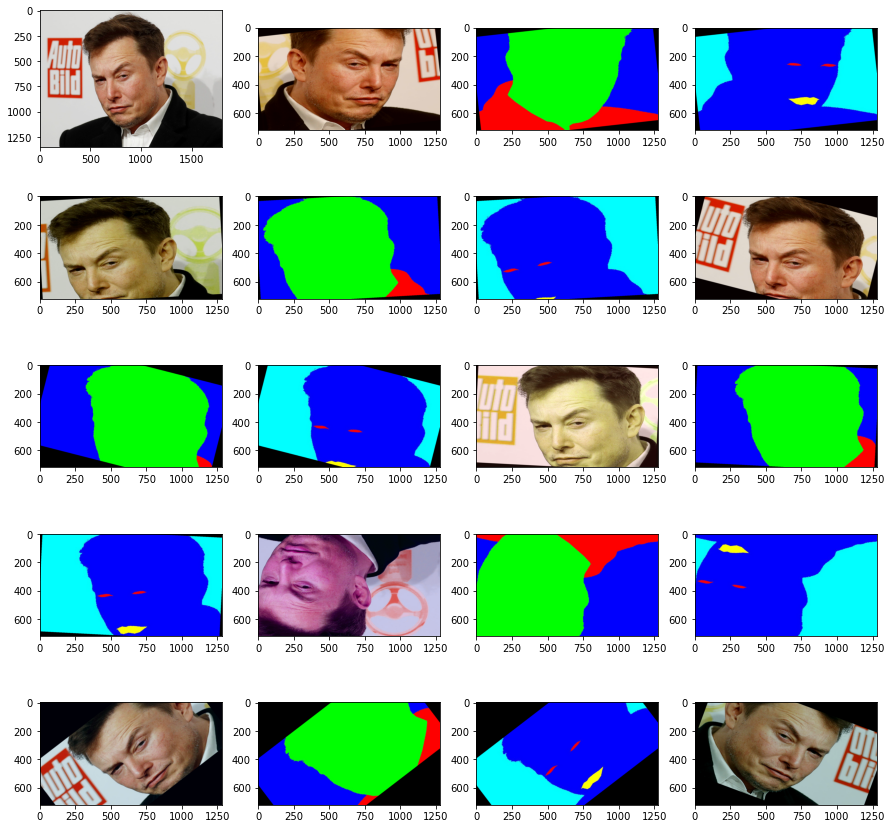

In [15]:
image = Image.open("images/elon.jpeg")
mask = Image.open("images/mask.jpeg")
mask2 = Image.open("images/second_mask.jpeg")
transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ],p=1.0),
        
    ]
)

images_list = [image]
image = np.array(image)
mask = np.array(mask)
mask2 = np.array(mask2)

for i in range(15):
    augmentations = transform(image=image,masks=[mask,mask2])
    augmented_img = augmentations["image"]
    augmented_mask = augmentations["masks"]

    images_list.append(augmented_img)
    images_list.append(augmented_mask[0])
    images_list.append(augmented_mask[1])

    
plot_examples(images_list)


## Detection 

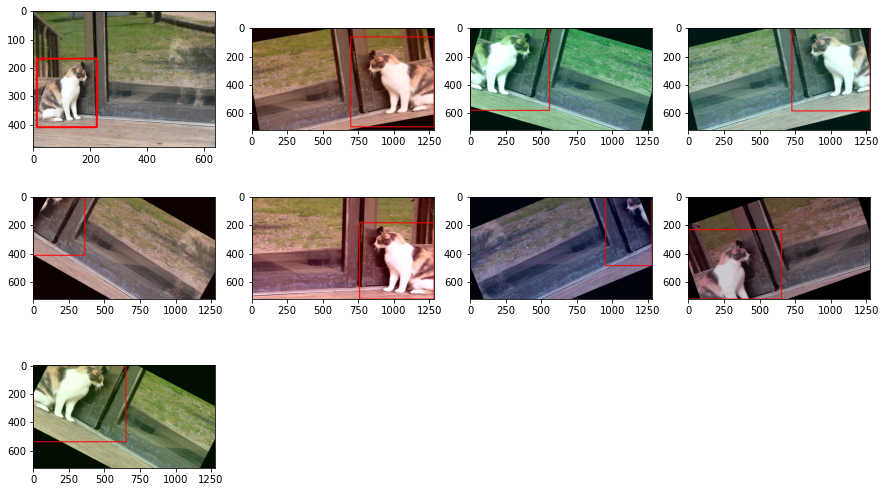

In [25]:
image = cv2.imread("images/cat.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = [[13, 170, 224, 410]]

transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ],p=1.0),  
    ], 
    bbox_params=A.BboxParams(format="pascal_voc",
                             min_area=2048,
                             min_visibility=0.3,
                             label_fields=[])
)

images_list = [image]
# image = np.array(image)
saved_bboxes = [bboxes[0]]

for i in range(15):
    augmentations = transform(image=image,bboxes=bboxes)
    augmented_img = augmentations["image"]
#     augmented_mask = augmentations["masks"]
    if len(augmentations["bboxes"])==0:
        continue
    images_list.append(augmented_img)
    saved_bboxes.append(augmentations["bboxes"][0])
    
#     images_list.append(augmented_mask[0])
#     images_list.append(augmented_mask[1])

    
plot_examples(images_list,saved_bboxes)


## Full pytorch example

In [3]:
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as transforms
# from torchvision.utils import save_image
import os
from torch.utils.data import Dataset, DataLoader

In [14]:
class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        super(ImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)
        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(self.root_dir, name))
            self.data += list(zip(files, len(files)*[index]))
            
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image_name, label = self.data[index]
        sub_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(sub_dir, image_name)))
        if self.transform:
            augmentations = self.transform(image=image) # bboxes=bboxes
            image = augmentations["image"]
            
        return image, label
    

In [22]:
transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ],p=1.0),
        A.Normalize(
                    mean=[0, 0, 0],
                   std=[1, 1, 1],
                   max_pixel_value=255),
        ToTensorV2(),
    ]
)


In [23]:
dataset = ImageFolder(root_dir="cat_dogs", transform=transform)

In [24]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [25]:
for x, y in loader:
    print(x.shape)
    print(y.shape)
#     break

torch.Size([8, 3, 720, 1280])
torch.Size([8])
torch.Size([8, 3, 720, 1280])
torch.Size([8])
torch.Size([3, 3, 720, 1280])
torch.Size([3])
